In [7]:
import numpy as np
from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [8]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

In [9]:
def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [10]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix \n ===>', mcm)
            
    return results_dict

In [11]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels 
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                idx = np.where(P_pred[i,:]==np.max(P_pred[i,:]))
                y_pred.append(np.random.choice(idx[0]))
                
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    print('!!! confusion_mx : \n ', confusion_mx)
    results_dict.update({'Confusion_mx':confusion_mx})
    
    return results_dict

In [12]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

In [14]:
def fit_MNB(Y, H):
    '''
    Fit Multinomial Naive Bayes Calssifier
    Use the Maximum Likelihood prior and class conditional probabilities (in closed forms)
    Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
    prior on class labels = empirical PMF = [ # class i examples / total ]
    class-conditional for class i = [ # word j in class i examples / # words in class i examples]
    Output = prior (k, ), class_conditional_PMF = (k, p)
    '''
    k = Y.shape[1] # number of classes 

    prior = np.sum(Y, axis=0)/np.sum(np.sum(Y, axis=0))

    class_conditional_PMF = []
    for i in np.arange(Y.shape[1]):
        idx = np.where(Y[:,i]==1)
        sub_H = H[:,idx[0]] + 1# add psuedocount
        word_count_per_class = np.sum(sub_H, axis=1)
        class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))

    return prior, np.asarray(class_conditional_PMF)

In [15]:
def predict_MNB(X_test, prior, class_conditional_PMF):
    '''
    Compute predicted PMF for the test data given prior and class_conditional_PMF
    Simple use of Bayes' Theorem 
    X_test = (p x n) (words x docs)
    '''
    
    P = class_conditional_PMF / np.min(class_conditional_PMF) # normalize so that log(P) is not too small 
    Q = np.exp(X_test @ np.log(P).T)
    Q = Q * np.repeat(prior[:, np.newaxis], repeats=Q.shape[0], axis=1).T
    sum_of_rows = Q.sum(axis=1)
    
    predictive_PMF = Q / sum_of_rows[:, np.newaxis]
    predictive_PMF = np.asarray(predictive_PMF)
    predictive_PMF = np.concatenate(predictive_PMF, axis=None)
    return predictive_PMF

In [21]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

In [22]:
from tqdm import trange

def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

In [ ]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix \n ===>', mcm)
            
    return results_dict

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 51471.78it/s]


AUC ===> 0.994
Opt_threshold ===> 0.665
Accuracy ===> 0.984
Sensitivity ===> 0.990
Specificity ===> 0.960
Precision ===> 0.960
Fall_out ===> 0.010
Miss_rate ===> 0.040
Confusion matrix 
 ===> [[198   2]
 [  2  48]]
AUC ===> 0.977
Opt_threshold ===> 0.123
Accuracy ===> 0.947
Sensitivity ===> 0.969
Specificity ===> 0.858
Precision ===> 0.873
Fall_out ===> 0.031
Miss_rate ===> 0.142
Confusion matrix 
 ===> [[27714   890]
 [ 1016  6135]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 46894.78it/s]


AUC ===> 0.939
Opt_threshold ===> 0.421
Accuracy ===> 0.904
Sensitivity ===> 0.950
Specificity ===> 0.720
Precision ===> 0.783
Fall_out ===> 0.050
Miss_rate ===> 0.280
Confusion matrix 
 ===> [[190  10]
 [ 14  36]]
AUC ===> 0.721
Opt_threshold ===> 0.132
Accuracy ===> 0.779
Sensitivity ===> 0.875
Specificity ===> 0.393
Precision ===> 0.441
Fall_out ===> 0.125
Miss_rate ===> 0.607
Confusion matrix 
 ===> [[25197  3595]
 [ 4367  2831]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 43510.30it/s]


AUC ===> 0.925
Opt_threshold ===> 0.028
Accuracy ===> 0.900
Sensitivity ===> 0.945
Specificity ===> 0.720
Precision ===> 0.766
Fall_out ===> 0.055
Miss_rate ===> 0.280
Confusion matrix 
 ===> [[189  11]
 [ 14  36]]
AUC ===> 0.557
Opt_threshold ===> 0.001
Accuracy ===> 0.711
Sensitivity ===> 0.831
Specificity ===> 0.231
Precision ===> 0.255
Fall_out ===> 0.169
Miss_rate ===> 0.769
Confusion matrix 
 ===> [[23560  4784]
 [ 5446  1640]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 35442.67it/s]


AUC ===> 0.980
Opt_threshold ===> 0.387
Accuracy ===> 0.964
Sensitivity ===> 0.985
Specificity ===> 0.880
Precision ===> 0.936
Fall_out ===> 0.015
Miss_rate ===> 0.120
Confusion matrix 
 ===> [[197   3]
 [  6  44]]
AUC ===> 0.530
Opt_threshold ===> 0.001
Accuracy ===> 0.716
Sensitivity ===> 0.844
Specificity ===> 0.204
Precision ===> 0.247
Fall_out ===> 0.156
Miss_rate ===> 0.796
Confusion matrix 
 ===> [[24186  4474]
 [ 5700  1465]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 46427.72it/s]


AUC ===> 0.996
Opt_threshold ===> 0.025
Accuracy ===> 0.962
Sensitivity ===> 0.978
Specificity ===> 0.900
Precision ===> 0.909
Fall_out ===> 0.022
Miss_rate ===> 0.100
Confusion matrix 
 ===> [[391   9]
 [ 10  90]]
AUC ===> 0.988
Opt_threshold ===> 0.122
Accuracy ===> 0.960
Sensitivity ===> 0.977
Specificity ===> 0.895
Precision ===> 0.905
Fall_out ===> 0.023
Miss_rate ===> 0.105
Confusion matrix 
 ===> [[28114   674]
 [  754  6443]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 43513.76it/s]


AUC ===> 0.917
Opt_threshold ===> 0.437
Accuracy ===> 0.914
Sensitivity ===> 0.960
Specificity ===> 0.730
Precision ===> 0.820
Fall_out ===> 0.040
Miss_rate ===> 0.270
Confusion matrix 
 ===> [[384  16]
 [ 27  73]]
AUC ===> 0.766
Opt_threshold ===> 0.162
Accuracy ===> 0.810
Sensitivity ===> 0.900
Specificity ===> 0.450
Precision ===> 0.530
Fall_out ===> 0.100
Miss_rate ===> 0.550
Confusion matrix 
 ===> [[25773  2855]
 [ 3933  3224]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 41230.47it/s]


AUC ===> 0.835
Opt_threshold ===> 0.288
Accuracy ===> 0.848
Sensitivity ===> 0.927
Specificity ===> 0.530
Precision ===> 0.646
Fall_out ===> 0.072
Miss_rate ===> 0.470
Confusion matrix 
 ===> [[371  29]
 [ 47  53]]
AUC ===> 0.545
Opt_threshold ===> 0.001
Accuracy ===> 0.729
Sensitivity ===> 0.857
Specificity ===> 0.214
Precision ===> 0.273
Fall_out ===> 0.143
Miss_rate ===> 0.786
Confusion matrix 
 ===> [[23819  3969]
 [ 5457  1490]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 33176.59it/s]


AUC ===> 0.880
Opt_threshold ===> 0.082
Accuracy ===> 0.846
Sensitivity ===> 0.915
Specificity ===> 0.570
Precision ===> 0.626
Fall_out ===> 0.085
Miss_rate ===> 0.430
Confusion matrix 
 ===> [[366  34]
 [ 43  57]]
AUC ===> 0.519
Opt_threshold ===> 0.001
Accuracy ===> 0.706
Sensitivity ===> 0.834
Specificity ===> 0.193
Precision ===> 0.225
Fall_out ===> 0.166
Miss_rate ===> 0.807
Confusion matrix 
 ===> [[24432  4868]
 [ 5908  1417]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 48364.29it/s]


AUC ===> 0.993
Opt_threshold ===> 0.137
Accuracy ===> 0.964
Sensitivity ===> 0.978
Specificity ===> 0.910
Precision ===> 0.910
Fall_out ===> 0.022
Miss_rate ===> 0.090
Confusion matrix 
 ===> [[782  18]
 [ 18 182]]
AUC ===> 0.988
Opt_threshold ===> 0.118
Accuracy ===> 0.959
Sensitivity ===> 0.976
Specificity ===> 0.892
Precision ===> 0.903
Fall_out ===> 0.024
Miss_rate ===> 0.108
Confusion matrix 
 ===> [[27845   687]
 [  769  6364]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 42760.58it/s]


AUC ===> 0.868
Opt_threshold ===> 0.390
Accuracy ===> 0.875
Sensitivity ===> 0.940
Specificity ===> 0.615
Precision ===> 0.719
Fall_out ===> 0.060
Miss_rate ===> 0.385
Confusion matrix 
 ===> [[752  48]
 [ 77 123]]
AUC ===> 0.767
Opt_threshold ===> 0.209
Accuracy ===> 0.810
Sensitivity ===> 0.908
Specificity ===> 0.421
Precision ===> 0.533
Fall_out ===> 0.092
Miss_rate ===> 0.579
Confusion matrix 
 ===> [[25679  2613]
 [ 4092  2981]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 40670.00it/s]


AUC ===> 0.754
Opt_threshold ===> 0.156
Accuracy ===> 0.802
Sensitivity ===> 0.906
Specificity ===> 0.385
Precision ===> 0.507
Fall_out ===> 0.094
Miss_rate ===> 0.615
Confusion matrix 
 ===> [[725  75]
 [123  77]]
AUC ===> 0.563
Opt_threshold ===> 0.003
Accuracy ===> 0.732
Sensitivity ===> 0.866
Specificity ===> 0.195
Precision ===> 0.268
Fall_out ===> 0.134
Miss_rate ===> 0.805
Confusion matrix 
 ===> [[24481  3775]
 [ 5684  1380]]


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 35389.88it/s]


AUC ===> 0.756
Opt_threshold ===> 0.061
Accuracy ===> 0.782
Sensitivity ===> 0.881
Specificity ===> 0.385
Precision ===> 0.448
Fall_out ===> 0.119
Miss_rate ===> 0.615
Confusion matrix 
 ===> [[705  95]
 [123  77]]
AUC ===> 0.557
Opt_threshold ===> 0.013
Accuracy ===> 0.716
Sensitivity ===> 0.844
Specificity ===> 0.204
Precision ===> 0.246
Fall_out ===> 0.156
Miss_rate ===> 0.796
Confusion matrix 
 ===> [[24293  4487]
 [ 5730  1465]]


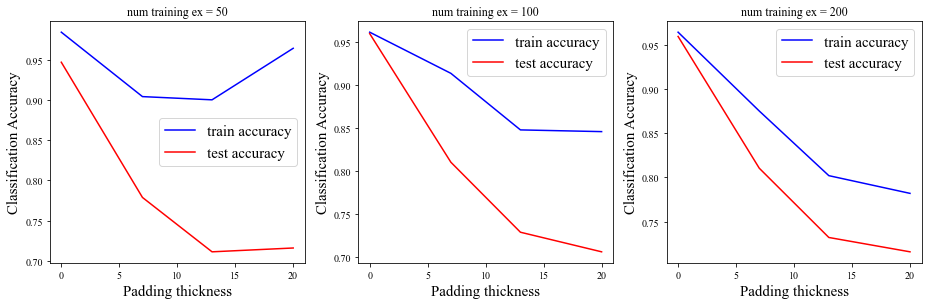

In [27]:
list_digits=['0', '1', '2','3','4']
padding_list=[0,7,13,20]
train_size_list=[50,100,200]


#make plot
ncols = len(train_size_list)
fig, ax =plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    
    for thickness in padding_list:
        X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, full_MNIST = [X,y], padding_thickness=thickness)
        idx = np.random.choice(np.arange(len(y_train)),train_size)
        X_train0 = X_train[idx,:]
        y_train0 = y_train[idx,:]
        prior, class_conditional_PMF = fit_MNB(Y=y_train0, H=X_train0.T)
        predictive_PMF_test = predict_MNB(X_test, prior, class_conditional_PMF)
        predictive_PMF_train = predict_MNB(X_train0, prior, class_conditional_PMF)
        y_train_1d=np.concatenate(y_train0, axis=None)
        y_test_1d=np.concatenate(y_test, axis=None)

        results_train = compute_accuracy_metrics(Y_test=y_train_1d, P_pred=predictive_PMF_train)
        results_test = compute_accuracy_metrics(Y_test=y_test_1d, P_pred=predictive_PMF_test)
        
        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
        
    ax[t].plot(padding_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(padding_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Padding thickness', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.9])